# Climate Indices with Earthkit & Xclim

This notebook demonstrates how to compute and visualize **climate indices** from CMIP6 datasets using the `earthkit-climate` and `xclim` packages.

We'll use:
- **Precipitation-based indices**:
  - *SDII*: Simple Daily Intensity Index (average precipitation on wet days)
  - *CWD*: Consecutive Wet Days (max number of wet days in a row)

- **Temperature-based indices**:
  - *DTR*: Daily Temperature Range (Tmax - Tmin)
  - *WSDI*: Warm Spell Duration Index (≥6 consecutive days above 90th percentile)
  - *HDD*: Heating Degree Days (based on temperature below threshold)

We’ll load **ACCESS-CM2 CMIP6 data** for both *historical* and *SSP585* scenarios.


In [36]:
import warnings

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import earthkit.data as ekd
import earthkit.plots as ekp
from earthkit.climate.indicators.precipitation import (
    daily_precipitation_intensity,
    maximum_consecutive_wet_days,
)
from earthkit.climate.indicators.temperature import (
    daily_temperature_range,
    heating_degree_days,
    warm_spell_duration_index,
)
from earthkit.climate.utils.percentile import calculate_percentile_doy

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 5)

## Loading CMIP6 data

We’ll use *daily gridded data* from the ACCESS-CM2 model for precipitation (`pr`), maximum (`tasmax`) and minimum (`tasmin`) temperature, for both historical and SSP585 future scenarios.


In [2]:
# Load precipitation
pr_hist = ekd.from_source(
    "url",
    "https://sites.ecmwf.int/repository/earthkit-climate/pr_gridded_day_CMIP6_ACCESS-CM2_r1i1p1f1_deepESD_day_historical.nc",
)
pr_ssp585 = ekd.from_source(
    "url",
    "https://sites.ecmwf.int/repository/earthkit-climate/pr_gridded_day_CMIP6_ACCESS-CM2_r1i1p1f1_deepESD_day_ssp585.nc",
)

# Load temperature
tasmin_hist = ekd.from_source(
    "url",
    "https://sites.ecmwf.int/repository/earthkit-climate/tasmin_gridded_day_CMIP6_ACCESS-CM2_r1i1p1f1_deepESD_day_historical.nc",
)
tasmin_ssp585 = ekd.from_source(
    "url",
    "https://sites.ecmwf.int/repository/earthkit-climate/tasmin_gridded_day_CMIP6_ACCESS-CM2_r1i1p1f1_deepESD_day_ssp585.nc",
)

tasmax_hist = ekd.from_source(
    "url",
    "https://sites.ecmwf.int/repository/earthkit-climate/tasmax_gridded_day_CMIP6_ACCESS-CM2_r1i1p1f1_deepESD_day_historical.nc",
)
tasmax_ssp585 = ekd.from_source(
    "url",
    "https://sites.ecmwf.int/repository/earthkit-climate/tasmax_gridded_day_CMIP6_ACCESS-CM2_r1i1p1f1_deepESD_day_ssp585.nc",
)

## Inspect and visualize the raw data

Before computing indices, let’s plot a few example grids to see how the raw variables look.


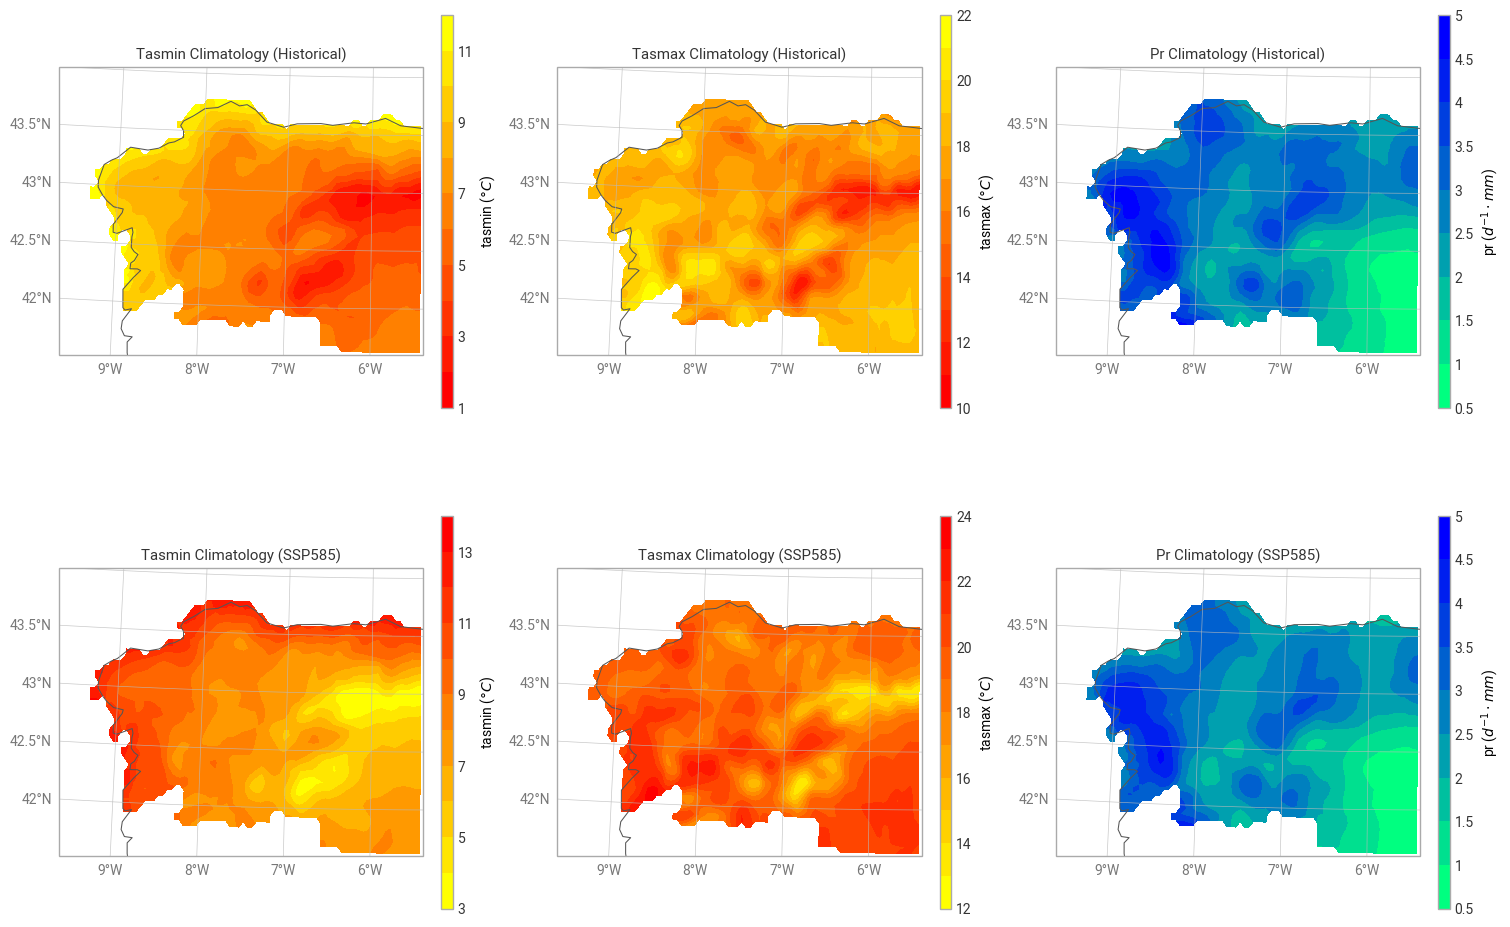

In [3]:
# Define domain (Spain north coast)
domain = [-9.6, -5.4, 41.6, 44.0]

# Create the figure with 2x2 maps
figure = ekp.Figure(
    crs=ccrs.NearsidePerspective(central_longitude=-5, central_latitude=43), rows=2, columns=3, size=(15, 10)
)

# Define variables and their datasets
variables = {
    "tasmin": (tasmin_hist, tasmin_ssp585, "celsius"),
    "tasmax": (tasmax_hist, tasmax_ssp585, "celsius"),
    "pr": (pr_hist, pr_ssp585, "mm/day"),
}

# HISTORICAL (row 0)
for col, (var, (hist, ssp, units)) in enumerate(variables.items()):
    hist_clim = hist.to_xarray().mean("time")
    cmap = "winter_r" if var == "pr" else "autumn"
    style = ekp.styles.Style(colors=cmap, units=units)
    map_plot = figure.add_map(row=0, column=col, domain=domain)
    map_plot.quickplot(hist_clim, style=style)
    map_plot.coastlines()
    map_plot.gridlines()
    map_plot.legend(location="right")
    map_plot.title(f"{var} Climatology (Historical)")

# SSP585 (row 1)
for col, (var, (hist, ssp, units)) in enumerate(variables.items()):
    ssp_clim = ssp.to_xarray().mean("time")
    cmap = "winter_r" if var == "pr" else "autumn_r"
    style = ekp.styles.Style(colors=cmap, units=units)
    map_plot = figure.add_map(row=1, column=col, domain=domain)
    map_plot.quickplot(ssp_clim, style=style)
    map_plot.coastlines()
    map_plot.gridlines()
    map_plot.legend(location="right")
    map_plot.title(f"{var} Climatology (SSP585)")

# Final layout
figure.show()

## Precipitation-based indices

We'll compute:
- **SDII** – Simple Daily Intensity Index (average rain on wet days)
- **CWD** – Consecutive Wet Days (max length of a wet period)


In [31]:
# SDII
sdii = daily_precipitation_intensity(pr_ssp585, thresh="1 mm/day", freq="YS")

# CWD
cwd = maximum_consecutive_wet_days(pr_ssp585, thresh="1 mm/day")

## Inspecting the computed precipitation indices

Now that we’ve calculated the precipitation-based indices (**SDII** and **CWD**),
let’s take a closer look at their structure and metadata.

We'll explore:
1. The list of fields available in each index object (`.ls()`).
2. The associated provenance and processing metadata (`.metadata()`).
3. The attributes of the resulting `xarray.Dataset` (`.to_xarray().attrs`).

This helps confirm that the computations ran correctly and to understand what information Earthkit keeps about each field.

In [27]:
# Inspect the SDII object (Simple Daily Intensity Index)
print("SDII fields:")
print(sdii.ls())

print("\nSDII metadata:")
print(sdii.metadata()[0])  # show first metadata entry

print("\nSDII xarray attributes:")
print(sdii.to_xarray().attrs)

SDII fields:
   variable level       valid_datetime   units
0      sdii  None  2015-01-01T00:00:00  mm d-1
1      sdii  None  2016-01-01T00:00:00  mm d-1
2      sdii  None  2017-01-01T00:00:00  mm d-1
3      sdii  None  2018-01-01T00:00:00  mm d-1
4      sdii  None  2019-01-01T00:00:00  mm d-1
5      sdii  None  2020-01-01T00:00:00  mm d-1
6      sdii  None  2021-01-01T00:00:00  mm d-1
7      sdii  None  2022-01-01T00:00:00  mm d-1
8      sdii  None  2023-01-01T00:00:00  mm d-1
9      sdii  None  2024-01-01T00:00:00  mm d-1
10     sdii  None  2025-01-01T00:00:00  mm d-1
11     sdii  None  2026-01-01T00:00:00  mm d-1
12     sdii  None  2027-01-01T00:00:00  mm d-1
13     sdii  None  2028-01-01T00:00:00  mm d-1
14     sdii  None  2029-01-01T00:00:00  mm d-1
15     sdii  None  2030-01-01T00:00:00  mm d-1
16     sdii  None  2031-01-01T00:00:00  mm d-1
17     sdii  None  2032-01-01T00:00:00  mm d-1
18     sdii  None  2033-01-01T00:00:00  mm d-1
19     sdii  None  2034-01-01T00:00:00  mm d-1


### Notes on SDII metadata

- The **metadata** includes details such as the processing history, indicator name, variable units, and temporal frequency.
- `earthkit-climate` attaches provenance automatically through its integration with `xclim`, ensuring full traceability.
- You can also explore the `sdii.to_xarray()` object directly to see the data variables and dimensions.


In [28]:
# Inspect the CWD object (Maximum Consecutive Wet Days)
print("CWD fields:")
print(cwd.ls())

print("\nCWD metadata:")
print(cwd.metadata()[0])

print("\nCWD xarray attributes:")
print(cwd.to_xarray().attrs)

CWD fields:
   variable level       valid_datetime units
0       cwd  None  2015-01-01T00:00:00  days
1       cwd  None  2016-01-01T00:00:00  days
2       cwd  None  2017-01-01T00:00:00  days
3       cwd  None  2018-01-01T00:00:00  days
4       cwd  None  2019-01-01T00:00:00  days
5       cwd  None  2020-01-01T00:00:00  days
6       cwd  None  2021-01-01T00:00:00  days
7       cwd  None  2022-01-01T00:00:00  days
8       cwd  None  2023-01-01T00:00:00  days
9       cwd  None  2024-01-01T00:00:00  days
10      cwd  None  2025-01-01T00:00:00  days
11      cwd  None  2026-01-01T00:00:00  days
12      cwd  None  2027-01-01T00:00:00  days
13      cwd  None  2028-01-01T00:00:00  days
14      cwd  None  2029-01-01T00:00:00  days
15      cwd  None  2030-01-01T00:00:00  days
16      cwd  None  2031-01-01T00:00:00  days
17      cwd  None  2032-01-01T00:00:00  days
18      cwd  None  2033-01-01T00:00:00  days
19      cwd  None  2034-01-01T00:00:00  days
20      cwd  None  2035-01-01T00:00:00  day

### Notes on CWD metadata

- The **CWD** (Consecutive Wet Days) index records the longest sequence of wet days (above a threshold, typically 1 mm/day) per period.
- Similar to SDII, it retains detailed provenance, so you know exactly which dataset, variable, and indicator were used.
- These attributes are critical for reproducibility in climate data analysis.


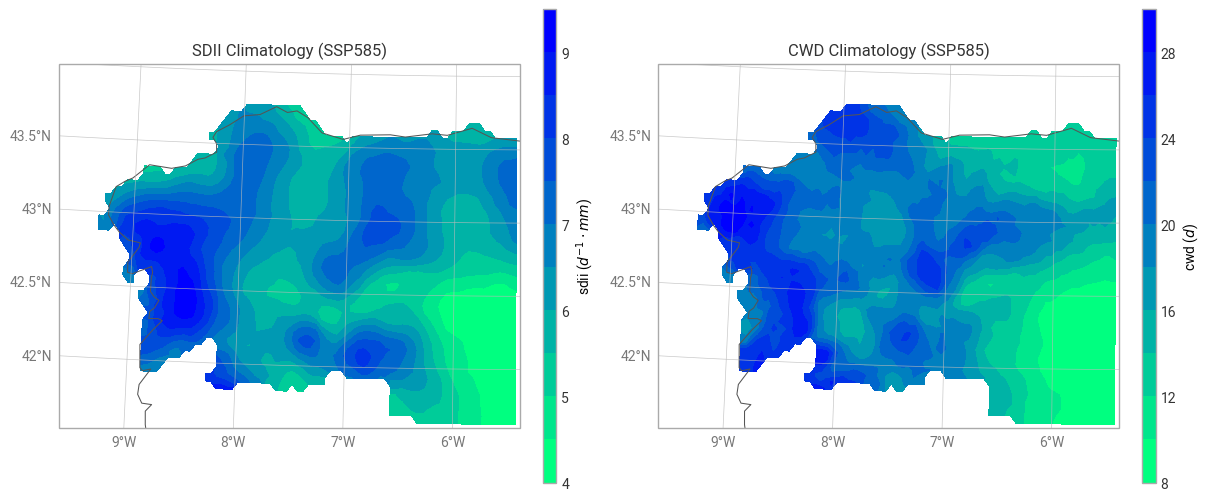

In [32]:
# Define domain (Spain north coast)
domain = [-9.6, -5.4, 41.6, 44.0]

# Create figure: 1 row (2 indices) × 2 scenarios (historical + ssp585)
figure = ekp.Figure(
    crs=ccrs.NearsidePerspective(central_longitude=-5, central_latitude=43), rows=1, columns=2, size=(12, 6)
)

# Define indices and corresponding datasets
indices = {"SDII": sdii, "CWD": cwd}

# Define color maps for each index
cmaps = {"SDII": "winter_r", "CWD": "winter_r"}

units = {"SDII": "mm/day", "CWD": "days"}

# PLOT: Each index climatology
for col, (name, index_obj) in enumerate(indices.items()):
    ds = index_obj.to_xarray().mean("time")
    cmap = cmaps[name]

    style = ekp.styles.Style(colors=cmap, units=units[name])
    map_plot = figure.add_map(row=0, column=col, domain=domain)
    map_plot.quickplot(ds, style=style)
    map_plot.coastlines()
    map_plot.gridlines()
    map_plot.title(f"{name} Climatology (SSP585)")
    map_plot.legend(location="right")

# Final layout
figure.show()

## Temperature-based indices

Now we’ll compute:
- **DTR** – Daily Temperature Range
- **WSDI** – Warm Spell Duration Index (based on 90th percentile)
- **HDD** – Heating Degree Days


In [63]:
# DTR
dtr = daily_temperature_range(ds=(tasmax_ssp585 + tasmin_ssp585))

# WSDI (using historical baseline)
# Calculate 90th percentile from historical data
tasmax_per = calculate_percentile_doy(tasmax_hist.to_xarray(), variable="tasmax", percentile=90)

# Merge percentile with target dataset
ds_merged = tasmax_ssp585.to_xarray().merge(tasmax_per)

wsdi = warm_spell_duration_index(ds=ds_merged)

# HDD (approximation)
tas = (tasmax_ssp585.to_xarray()["tasmax"] + tasmin_ssp585.to_xarray()["tasmin"]) / 2
tas.attrs["units"] = "degC"
tas = tas.to_dataset(name="tas")
hdd = heating_degree_days(
    ds=ekd.from_source(
        "multi",
        ekd.from_object(tasmax_ssp585.to_xarray()),
        ekd.from_object(tasmin_ssp585.to_xarray()),
        ekd.from_object(tas),
    )
)

ekd.from_object(tas)## Inspecting the temperature-based indices

Now let's explore the three temperature indices we calculated:

1. **DTR (Daily Temperature Range)** — Difference between daily maximum and minimum temperatures.
2. **WSDI (Warm Spell Duration Index)** — Number of warm spells: consecutive periods (≥6 days) above the 90th percentile of the historical period.
3. **HDD (Heating Degree Days)** — Heating degree days, estimating heating energy demand based on temperatures below a threshold.

For each index, we’ll check:
- The available fields (`.ls()`).
- The metadata and provenance (`.metadata()`).
- The dataset attributes (`.to_xarray().attrs`).

This helps us confirm that the results and units are consistent and properly documented.


In [64]:
# DTR (Daily Temperature Range)
print("DTR fields:")
print(dtr.ls())

print("\n DTR metadata:")
print(dtr.metadata()[0])

print("\n DTR xarray attributes:")
print(dtr.to_xarray().attrs)

DTR fields:
   variable level       valid_datetime units
0       dtr  None  2015-01-01T00:00:00     K
1       dtr  None  2016-01-01T00:00:00     K
2       dtr  None  2017-01-01T00:00:00     K
3       dtr  None  2018-01-01T00:00:00     K
4       dtr  None  2019-01-01T00:00:00     K
5       dtr  None  2020-01-01T00:00:00     K
6       dtr  None  2021-01-01T00:00:00     K
7       dtr  None  2022-01-01T00:00:00     K
8       dtr  None  2023-01-01T00:00:00     K
9       dtr  None  2024-01-01T00:00:00     K
10      dtr  None  2025-01-01T00:00:00     K
11      dtr  None  2026-01-01T00:00:00     K
12      dtr  None  2027-01-01T00:00:00     K
13      dtr  None  2028-01-01T00:00:00     K
14      dtr  None  2029-01-01T00:00:00     K
15      dtr  None  2030-01-01T00:00:00     K
16      dtr  None  2031-01-01T00:00:00     K
17      dtr  None  2032-01-01T00:00:00     K
18      dtr  None  2033-01-01T00:00:00     K
19      dtr  None  2034-01-01T00:00:00     K
20      dtr  None  2035-01-01T00:00:00     

### Notes on DTR

- Represents the **daily temperature range**, a key measure of local temperature variability.
- The metadata contains information about the input variables (`tasmax`, `tasmin`), their units, and the indicator method used.
- Always check that the output units (`degC`) are correct and consistent with the inputs.


In [65]:
# WSDI (Warm Spell Duration Index)
print("WSDI fields:")
wsdi.ls()

print("\n WSDI metadata:")
print(wsdi.metadata()[0])

print("\n WSDI xarray attributes:")
print(wsdi.to_xarray().attrs)

WSDI fields:

 WSDI metadata:
XArrayMetadata({'units': 'days', 'cell_methods': ' time: sum over days', 'history': "[2025-12-01 23:20:39] warm_spell_duration_index: WARM_SPELL_DURATION_INDEX(tasmax=tasmax, tasmax_per=tasmax_per, window=6, freq='YS', resample_before_rl=True, bootstrap=False, op='>') with options check_missing=any - xclim version: 0.59.1\ntasmax: \ntasmax_per: [2025-12-01 23:20:38] per: percentile_doy(arr=tasmax, window=6, per=90, alpha=0.3333333333333333, beta=0.3333333333333333, copy=True) - xclim version: 0.59.1\n", 'standard_name': 'number_of_days_with_air_temperature_above_threshold', 'long_name': 'Number of days with at least 6 consecutive days where the maximum daily temperature is above the [90]th percentile(s)', 'description': "Annual number of days with at least 6 consecutive days where the maximum daily temperature is above the [90]th percentile(s). a 6 day(s) window, centred on each calendar day in the ['1995-01-01', '2014-12-31'] period, is used to compute th

In [66]:
# HDD (Heating Degree Days)
print("HDD fields:")
print(hdd.ls())

print("\n HDD metadata:")
print(hdd.metadata()[0])

print("\n HDD xarray attributes:")
print(hdd.to_xarray().attrs)

HDD fields:
               variable level       valid_datetime   units
0   heating_degree_days  None  2015-01-01T00:00:00  K days
1   heating_degree_days  None  2016-01-01T00:00:00  K days
2   heating_degree_days  None  2017-01-01T00:00:00  K days
3   heating_degree_days  None  2018-01-01T00:00:00  K days
4   heating_degree_days  None  2019-01-01T00:00:00  K days
5   heating_degree_days  None  2020-01-01T00:00:00  K days
6   heating_degree_days  None  2021-01-01T00:00:00  K days
7   heating_degree_days  None  2022-01-01T00:00:00  K days
8   heating_degree_days  None  2023-01-01T00:00:00  K days
9   heating_degree_days  None  2024-01-01T00:00:00  K days
10  heating_degree_days  None  2025-01-01T00:00:00  K days
11  heating_degree_days  None  2026-01-01T00:00:00  K days
12  heating_degree_days  None  2027-01-01T00:00:00  K days
13  heating_degree_days  None  2028-01-01T00:00:00  K days
14  heating_degree_days  None  2029-01-01T00:00:00  K days
15  heating_degree_days  None  2030-01-01T00

### Notes on HDD

- The **Heating Degree Days** index estimates heating demand based on temperatures below a threshold (typically 18 °C).
- Metadata document the base temperature, frequency of accumulation, and calculation method (approximation).
- HDD is a valuable indicator for **energy and climate impact assessments**.


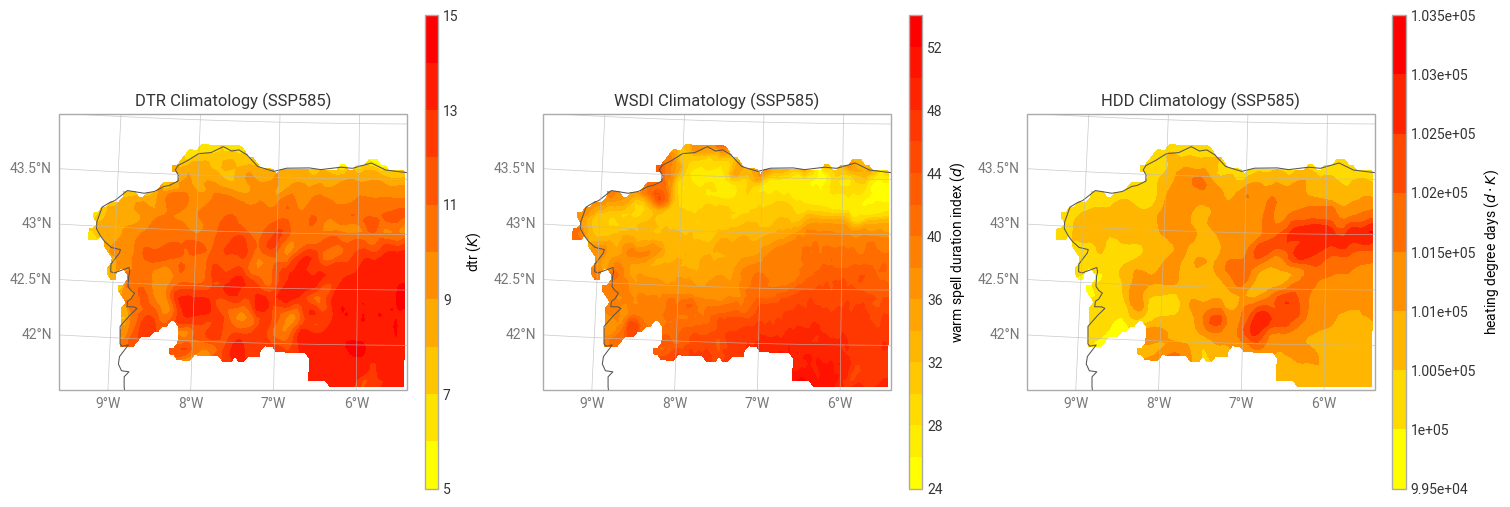

In [67]:
# Define domain (Spain north coast)
domain = [-9.6, -5.4, 41.6, 44.0]

# Create figure: 1 row (2 indices) × 2 scenarios (historical + ssp585)
figure = ekp.Figure(
    crs=ccrs.NearsidePerspective(central_longitude=-5, central_latitude=43), rows=1, columns=3, size=(15, 6)
)

# Define indices and corresponding datasets
indices = {"DTR": dtr, "WSDI": wsdi, "HDD": hdd}

# Define color maps for each index
cmaps = {"DTR": "autumn_r", "WSDI": "autumn_r", "HDD": "autumn_r"}

units = {"DTR": "K", "WSDI": "days", "HDD": "K days"}

# PLOT: Each index climatology
for col, (name, index_obj) in enumerate(indices.items()):
    ds = index_obj.to_xarray().mean("time")
    cmap = cmaps[name]

    style = ekp.styles.Style(colors=cmap, units=units[name])
    map_plot = figure.add_map(row=0, column=col, domain=domain)
    map_plot.quickplot(ds, style=style)
    map_plot.coastlines()
    map_plot.gridlines()
    map_plot.title(f"{name} Climatology (SSP585)")
    map_plot.legend(location="right")

figure.show()